# Project Title

## Introduction and description

 This dataset contains information from inspections of restaurants and other
food establishments in Chicago from January 1, 2010 to the present. 

(...)

## Exploratory Data Analysis

**Data Loading**

In [380]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings

In [381]:
food_inspections = pd.read_csv('data/food-inspections.csv', sep=',')

In [382]:
food_inspections.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Results', 'Violations', 'Latitude', 'Longitude',
       'Location', 'Historical Wards 2003-2015', 'Zip Codes',
       'Community Areas', 'Census Tracts', 'Wards'],
      dtype='object')

In [383]:
# Check format
print(food_inspections['Historical Wards 2003-2015'].unique())
print(food_inspections['Zip Codes'].unique())
print(food_inspections['Community Areas'].unique())
print(food_inspections['Census Tracts'].unique())
print(food_inspections['Wards'].unique())
#print(food_inspections['Zip'].unique())

[nan]
[nan]
[nan]
[nan]
[nan]


**Remove the columns containing only 'NaN'**

We remove the 'Zip' column as well because it is not useful.

In [384]:
food_inspections.drop(['Zip', 'Zip Codes','Historical Wards 2003-2015', 'Community Areas', 
                       'Census Tracts','Wards'], axis=1, inplace=True)

**Create Year Column**

In [385]:
food_inspections['Year'] = food_inspections['Inspection Date'].apply(lambda x: x.split('-')[0])

### Studying the Violations

We check if there are entries with no violations. If there is no violation, nothing was detected in those restaurants.

In [386]:
food_inspections['Violations'].isnull().values.any()

True

In [387]:
print('Total number of entries in the dataset: {0}'.format(food_inspections.shape[0]))

Total number of entries in the dataset: 194904


In [388]:
print('Total number of entries with no violations in the dataset: {0}'\
      .format(food_inspections[food_inspections['Violations'].isnull()].shape[0]))
per = food_inspections[food_inspections['Violations'].isnull()].shape[0]/food_inspections.shape[0]
print('Corresponding the following percentage of entries: {0:.2f}'\
      .format(per))

Total number of entries with no violations in the dataset: 51683
Corresponding the following percentage of entries: 0.27


We fill those NaN values with the tag 'No Violation' for better readibility during counting. We will then inspect the violations data to see its shape.

In [389]:
food_inspections['Violations'].fillna('No Violation', inplace=True)

We observe that the violations are referenced using a 'number', a 'description' and a comment for more specificities. In our case, we don't need the comment part so we delete it. The 'Violations' column can as well contain more than one violation type, we can split those into arrays and create a new violation-based dataset.

In [390]:
food_inspections['Violations'] = food_inspections.Violations.apply(lambda x: x.split('- Comments:')[0])

In [391]:
len(food_inspections['Violations'].unique())

235

In [392]:
food_inspections['Violations'] = np.array(food_inspections.Violations.apply(lambda x: x.split('|')))

In [393]:
violations = food_inspections.explode('Violations')\
                    .rename(columns={'Violations':'Violation'}) \
                    .reset_index(drop=True) \
                    .dropna(subset=['Violation']) \
                    .set_index('Violation') \
                    .reset_index()

In [394]:
len(violations.Violation.unique())

172

In [395]:
violations['Violation ID'] = violations['Violation']
violations['Violation ID'] = violations['Violation ID'].apply(lambda x: x.split('.')[0])

**Count using ID**

In [396]:
violation_count = violations[['Violation ID','Inspection ID']].groupby('Violation ID')\
                    .count()\
                    .sort_values(by='Inspection ID', ascending=False)\
                    .rename(columns={'Inspection ID':'Occurence'})

In [397]:
violation_count.head()

,Occurence
Violation ID,
No Violation,51683
32,25437
33,17456
3,13582
34,10589


In [398]:
violation_count.shape

(100, 1)

**Count using Name**

In [399]:
violation_count_name = violations[['Violation','Inspection ID']].groupby('Violation')\
                    .count()\
                    .sort_values(by='Inspection ID', ascending=False)\
                    .rename(columns={'Inspection ID':'Occurence'})

In [400]:
violation_count_name.head()

,Occurence
Violation,
No Violation,51683
"32. FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED",25434
"33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS",17430
"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED",10587
"18. NO EVIDENCE OF RODENT OR INSECT OUTER OPENINGS PROTECTED/RODENT PROOFED, A WRITTEN LOG SHALL BE MAINTAINED AVAILABLE TO THE INSPECTORS",10002


In [401]:
violation_count_name.shape

(172, 1)

**Plotting Violations**

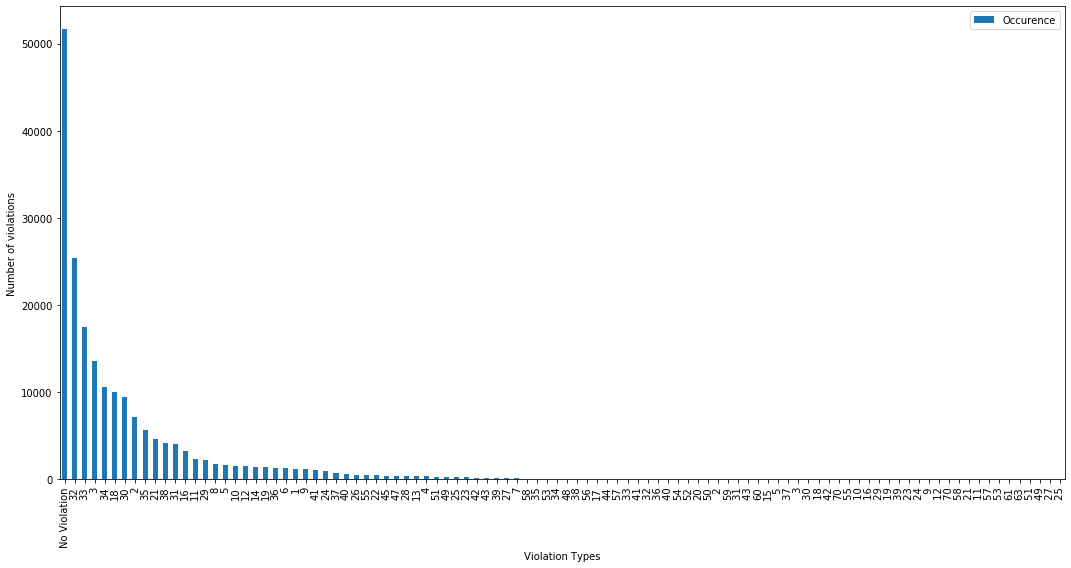

In [402]:
#Here we plot the number of ocurrences of each violations for a quick visualization of the situation
ax = violation_count.plot(kind='bar',figsize = [15,8])
ax.set_xlabel('Violation Types')
ax.set_ylabel('Number of violations')
plt.tight_layout()

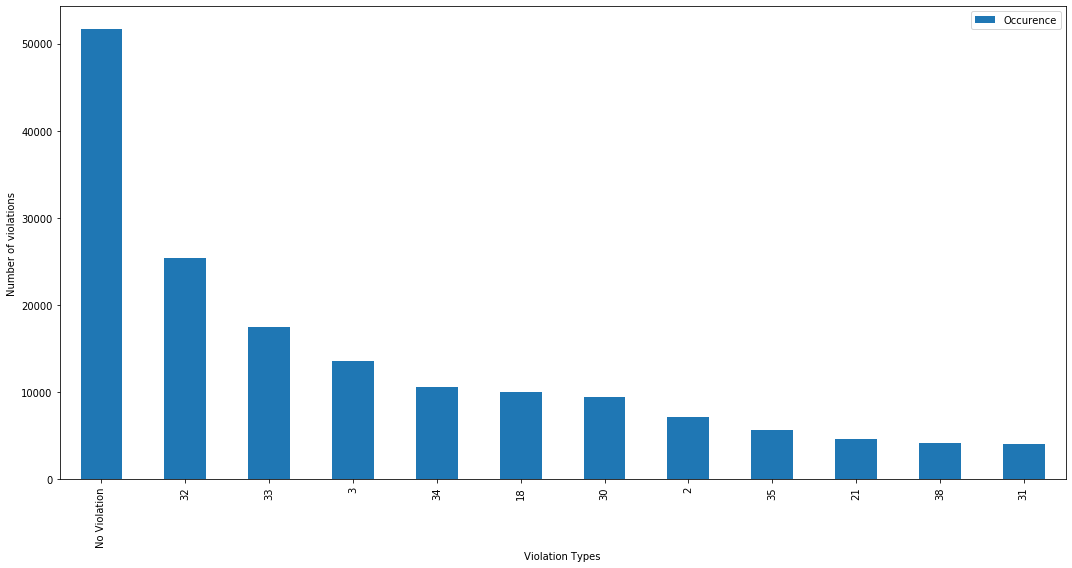

In [403]:
# Plot 13 top values
ax = violation_count.iloc[0:12].plot(kind='bar',figsize = [15,8])
ax.set_xlabel('Violation Types')
ax.set_ylabel('Number of violations')
plt.tight_layout()

In [404]:
violations[violations['Violation ID'] == '32'].head()

,Violation,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Inspection Date,Inspection Type,Results,Latitude,Longitude,Location,Year,Violation ID
22087,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,2182155,RAVENS,RAVENS,8638.0,TAVERN,Risk 3 (Low),2326 N CLARK ST,CHICAGO,IL,2018-06-29T00:00:00.000,Complaint Re-Inspection,Pass,41.924442,-87.639932,"{'latitude': '-87.63993233882339', 'longitude'...",2018,32
22089,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,2182159,J & R COCKTAIL LOUNGE,J & R COCKTAIL LOUNGE,946.0,Liquor,Risk 3 (Low),612 E 79TH ST,CHICAGO,IL,2018-06-29T00:00:00.000,Complaint Re-Inspection,Pass,41.751319,-87.609522,"{'latitude': '-87.60952232294443', 'longitude'...",2018,32
22093,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,2182165,WHIPPED & BEATEN CULINARY WORKS,WHIPPED & BEATEN CULINARY WORKS,2590079.0,COOKING SCHOOL,Risk 1 (High),3611-3617 N BROADWAY,CHICAGO,IL,2018-06-29T00:00:00.000,License Re-Inspection,Pass,41.947732,-87.647343,"{'latitude': '-87.64734303203468', 'longitude'...",2018,32
22094,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,2182160,CASA HERNANDEZ,CASA HERNANDEZ GROCERY STORE,1047126.0,Grocery Store,Risk 1 (High),1725 W LUNT,CHICAGO,IL,2018-06-29T00:00:00.000,Canvass Re-Inspection,Pass,42.008897,-87.673311,"{'latitude': '-87.67331123054235', 'longitude'...",2018,32
22095,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,2182172,PEPE'S RESTAURANT,PEPE'S RESTAURANT,7056.0,Restaurant,Risk 1 (High),7026 W ARCHER AVE,CHICAGO,IL,2018-06-29T00:00:00.000,Complaint,Pass,41.792140,-87.797669,"{'latitude': '-87.79766862419076', 'longitude'...",2018,32


**Violation List**

In [411]:
violation_list = violations[['Violation','Violation ID']]

In [412]:
violation_list = violation_list.drop_duplicates()

In [413]:
violation_list = violation_list.merge(violation_count, on='Violation ID')

In [414]:
violation_list.sort_values(by='Occurence', ascending='False', inplace=True)

In [459]:
violation_list.head()

,Violation,Violation ID,Occurence
171,"27. TOILET ROOMS ENCLOSED CLEAN, PROVIDED WIT...",27,1
81,61. SUMMARY REPORT DISPLAYED AND VISIBLE TO TH...,61,1
82,51. PLUMBING INSTALLED; PROPER BACKFLOW DEVICES,51,1
101,63. REMOVAL OF SUSPENSION SIGN,63,1
105,49. NON-FOOD/FOOD CONTACT SURFACES CLEAN,49,1


In [460]:
violation_list.shape

(172, 3)

**Violations per establishment**

In [476]:
violations_ = violations.copy()
violations = violations[violations['Violation'] != 'No Violation']

In [477]:
violation_resto = violations.groupby(['AKA Name','DBA Name', 'License #','Location'])\
                    .count()\
                    .sort_values(by='Inspection ID', ascending=False)

In [478]:
violation_resto = violation_resto[['Violation','Violation ID']]
violation_resto.reset_index(inplace=True)
violation_resto = violation_resto.rename(columns={'Violation ID':'Viol. ID Count', 'Violation':'Viol. Count'})

In [479]:
violation_resto.head()

,AKA Name,DBA Name,License #,Location,Viol. Count,Viol. ID Count
0,JEWEL FOOD STORE # 3345,JEWEL FOOD STORE # 3345,1142451.0,"{'latitude': '-87.62596114837754', 'longitude'...",43,43
1,FOOD 4 LESS,Food 4 Less Midwest #552,1596210.0,"{'latitude': '-87.66396688645497', 'longitude'...",41,41
2,MARIANO'S FRESH MARKET,MARIANO'S FRESH MARKET #8503,2083833.0,"{'latitude': '-87.61898671163952', 'longitude'...",39,39
3,TAQUERIA EL RANCHITO,TAQUERIA EL RANCHITO,60184.0,"{'latitude': '-87.71305610116421', 'longitude'...",38,38
4,ONE STOP FOOD & LIQUOR STORE,ONE STOP FOOD & LIQUOR STORE,1094.0,"{'latitude': '-87.59868884416672', 'longitude'...",38,38


In [481]:
violation_resto[violation_resto['AKA Name'] == 'MCDONALD\'S'].head()

,AKA Name,DBA Name,License #,Location,Viol. Count,Viol. ID Count
5,MCDONALD'S,MCDONALD'S,1490035.0,"{'latitude': '-87.62681267627248', 'longitude'...",37,37
39,MCDONALD'S,MCDONALD'S,33706.0,"{'latitude': '-87.70573359902552', 'longitude'...",27,27
62,MCDONALD'S,MCDONALD'S,1874347.0,"{'latitude': '-87.68338583887078', 'longitude'...",26,26
292,MCDONALD'S,MCDONALD'S,1514130.0,"{'latitude': '-87.62144916300736', 'longitude'...",20,20
363,MCDONALD'S,MCDONALD'S RESTAURANTS,2423993.0,"{'latitude': '-87.6630911433338', 'longitude':...",19,19


In [482]:
violation_resto_ids = violations.groupby(['AKA Name','DBA Name', 'License #','Location'])[['Violation ID','AKA Name','DBA Name', 'License #','Location']]

In [484]:
violation_resto_ids.head()

,Violation ID,AKA Name,DBA Name,License #,Location
1,3,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960.0,"{'latitude': '-87.6822915036914', 'longitude':..."
2,38,DANTE'S PIZZA,"DANTE'S PIZZA,INC.",2092884.0,"{'latitude': '-87.70372788811352', 'longitude'..."
3,3,LAO PENG YOU,LAO PENG YOU LLC,2694477.0,"{'latitude': '-87.6779378973854', 'longitude':..."
4,14,ARBOR,ARBOR,2363029.0,"{'latitude': '-87.69216904438716', 'longitude'..."
5,38,HARMONY RESTAURANT,HARMONY RESTAURANT,61757.0,"{'latitude': '-87.78540566160221', 'longitude'..."
...,...,...,...,...,...
195374,18,SUPER DOG'S SUBMARINES INC,SUPER DOG'S SUBMARINES INC,2008759.0,"{'latitude': '-87.65894640986417', 'longitude'..."
195375,33,ABE'S IN & OUT,ABE'S IN & OUT,1948539.0,"{'latitude': '-87.71725428906686', 'longitude'..."
195379,34,ST CHRYSOSTOM'S CHURCH DAY SCHOOL,ST CHRYSOSTOM'S CHURCH DAY SCHOOL,20575.0,"{'latitude': '-87.6302719697274', 'longitude':..."
195390,33,SAFAH FOOD & LIQUOR INC,SAFAH FOOD & LIQUOR INC,14103.0,"{'latitude': '-87.65396483351302', 'longitude'..."


In [474]:
if 'a' in 'al':
    print('hi')

hi


### Create Year Column

In [409]:
food_inspections['Year'] = food_inspections['Inspection Date'].apply(lambda x: x.split('-')[0])

In [410]:
food_inspections.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,Year
0,2320519,SALAM RESTAURANT,SALAM RESTAURANT,2002822.0,Restaurant,Risk 1 (High),4634-4636 N KEDZIE AVE,CHICAGO,IL,2019-10-25T00:00:00.000,Complaint Re-Inspection,Pass,[No Violation],41.965719,-87.708538,"{'latitude': '-87.70853756167853', 'longitude'...",2019
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960.0,Restaurant,Risk 1 (High),2114 W LAWRENCE AVE,CHICAGO,IL,2019-10-25T00:00:00.000,License Re-Inspection,Fail,"[3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL ...",41.968820,-87.682292,"{'latitude': '-87.6822915036914', 'longitude':...",2019
2,2320412,"DANTE'S PIZZA,INC.",DANTE'S PIZZA,2092884.0,Restaurant,Risk 1 (High),3028 W ARMITAGE AVE,CHICAGO,IL,2019-10-24T00:00:00.000,Canvass,Fail,"[38. INSECTS, RODENTS, & ANIMALS NOT PRESENT ]",41.917539,-87.703728,"{'latitude': '-87.70372788811352', 'longitude'...",2019
3,2320430,LAO PENG YOU LLC,LAO PENG YOU,2694477.0,Restaurant,Risk 1 (High),2020 W CHICAGO,CHICAGO,IL,2019-10-24T00:00:00.000,License Re-Inspection,Pass w/ Conditions,"[3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL ...",41.896005,-87.677938,"{'latitude': '-87.6779378973854', 'longitude':...",2019
4,2320384,ARBOR,ARBOR,2363029.0,Restaurant,Risk 1 (High),2545 W DIVERSEY AVE,CHICAGO,IL,2019-10-24T00:00:00.000,Recent Inspection,Pass w/ Conditions,[14. REQUIRED RECORDS AVAILABLE: SHELLSTOCK TA...,41.932025,-87.692169,"{'latitude': '-87.69216904438716', 'longitude'...",2019
